In [1]:
!pip install tensorflow

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

AttributeError: module 'numpy.core.multiarray' has no attribute 'from_dlpack'

In [3]:
stockdf = pd.read_csv("Stock_Price.csv",index_col=0, parse_dates=True, squeeze=True)

NameError: name 'pd' is not defined

In [11]:
stockdf.head(4)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-03,95.129997,95.349998,91.730003,92.769997,92.380569,8082800
2021-12-06,93.849998,96.889999,93.239998,96.010002,95.606987,6679900
2021-12-07,96.599998,98.330002,96.300003,97.550003,97.140518,5049000
2021-12-08,97.550003,98.940002,96.980003,98.279999,97.867447,4756800


In [33]:
stockdf.shape

(252, 6)

In [13]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
    df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df = normalize_data(stockdf)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-03,0.818661,0.803148,0.753019,0.753031,0.750342,0.230399
2021-12-06,0.787959,0.839323,0.788776,0.830045,0.827525,0.178170
2021-12-07,0.853922,0.873150,0.861236,0.866651,0.864210,0.117454
2021-12-08,0.876709,0.887479,0.877338,0.884003,0.881599,0.106575
2021-12-09,0.881986,0.869861,0.877812,0.873306,0.870879,0.080884


In [27]:
# given we have values of closing price for past 5 days, we want to predict the price of next day


def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.to_numpy() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


In [45]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)

In [46]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)



(221, 5, 6)
(221,)
(25, 5, 6)
(25,)


# LSTM

In [36]:
def lstm_model(trainx, trainy, neurons, lookback, features, epochs,batch_size=1, activation_func = "tanh"):
    X, y = trainx, trainy
    model = Sequential()
    # model.add(LSTM(4, activation='relu', input_shape=(n_steps, n_features)))
    model.add(LSTM(neurons, batch_input_shape=(batch_size,lookback, features), stateful=True))
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mean_squared_error')
    # X = X.reshape((X.shape[0], X.shape[1], n_features))
    X = X.reshape((X.shape[0], X.shape[1], features)) 
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False)
    return history, model

In [49]:
neurons=50
lookback=5
features=6
epochs=30
history_1, model_1 = lstm_model(X_train,y_train,neurons,lookback,features,epochs)

Epoch 1/30
221/221 [==============================] - 4s 4ms/step - loss: 0.0185
Epoch 2/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0132
Epoch 3/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0118
Epoch 4/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0112
Epoch 5/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0108
Epoch 6/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0106
Epoch 7/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0103
Epoch 8/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 9/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0101
Epoch 10/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0100
Epoch 11/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 12/30
221/221 [==============================] - 1s 4ms/step - loss: 0.0099
Epoch 13/30
221/221 [====

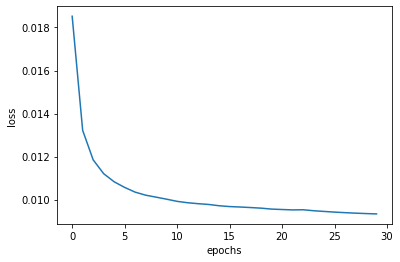

In [50]:
def plot_model_results(model):
    loss = model.history["loss"]
    plt.plot(loss)
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.show()
    
plot_model_results(history_1)

# GRU

In [53]:
def GRU_model(trainx, trainy, input_neurons, hidden_neurons, lookback, features, epochs,batch_size=128, dropout=0.5):
    X, y = trainx, trainy
    model = Sequential()
    model.add(GRU (input_neurons, dropout=0.5, return_sequences = True, input_shape=(lookback, features)))
    model.add(GRU(hidden_neurons, dropout=0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    X = X.reshape((X.shape[0], X.shape[1], features))
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False)
    return history, model

In [54]:
input_neurons=64
hidden_neurons=20
lookback=5
features=6
epochs=30
history2, model2 = GRU_model(X_train, X_train,input_neurons,hidden_neurons,lookback,features,epochs)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "C:\Users\92347\ansel\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\92347\ansel\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\92347\ansel\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\92347\ansel\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\92347\ansel\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\92347\ansel\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\92347\ansel\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\92347\ansel\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\92347\ansel\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\92347\ansel\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\92347\ansel\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\92347\ansel\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\92347\ansel\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\92347\ansel\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\92347\AppData\Local\Temp\ipykernel_9540\261557982.py", line 6, in <cell line: 6>
      history2, model2 = GRU_model(X_train, X_train,input_neurons,hidden_neurons,lookback,features,epochs)
    File "C:\Users\92347\AppData\Local\Temp\ipykernel_9540\1683845784.py", line 9, in GRU_model
      history = model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False)
    File "C:\Users\92347\ansel\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\92347\ansel\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\92347\ansel\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\92347\ansel\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\92347\ansel\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\92347\ansel\lib\site-packages\keras\engine\training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\92347\ansel\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "C:\Users\92347\ansel\lib\site-packages\keras\optimizers\optimizer_experimental\optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [128,1] vs. [128,5,6]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_73660]